In [6]:
import h5py
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
from constants import c, h, k
from PIL import Image, ImageOps
from IPython.display import display

\To calculate the emissivity in each bin, use the formula

$\Delta I_{\nu}^{\textrm{voxel}\ n,k}  = \tau_{353}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) 
= \rho_{353}^{k} \Delta E_{\textrm{B-V}}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) E_{\textrm{B-V}}^{n,k}$

where $k$ is indexing over the pixels in the sky, and $n$ is indexing over the distance bins



In [7]:
filename="All_data_3D_temperature_17_dist_bins_nside_128.hdf5"

In [8]:
def load_3D_temperature_data(file):
    data_dict = {}
    with h5py.File(file, "r") as g:    
        data_dict["temperatures"]=g["temperature"][()] # this is (healpix x distance_bin)
        data_dict["distance_slices"] = g["distance_slices"][()]
        data_dict["dEBV"] = g["dEBV_smooth"][()]
        data_dict["rhos"] = g["rhos"][()] 
        data_dict["betas"]= g["betas"][()]
        data_dict["nside"] = g.attrs["nside"]
        data_dict["nr_of_distance_bins"] = g.attrs["nr_of_distance_bins"]
        data_dict["healpix_ordering"] = g.attrs["healpix_ordering"] #nest
        data_dict["run_name"] = g.attrs["original_run_name"]
        g.close()
    return data_dict


In [9]:
def plot_3D_temperature_slice_maps(data_dict):
    Ts = data_dict["temperatures"]
    model_nslices = data_dict["nr_of_distance_bins"]
    model_dist_slices = data_dict["distance_slices"]
    for ds_index in range(model_nslices):                                 
        hp.mollview(Ts[:,ds_index],title=r"$T$ at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=10,max=25, unit='K')
        plt.savefig("T_128_"+str(ds_index)+".png")
      

def plot_rho(data_dict):
    """ Assumes rho was fixed along the line of sight"""
    rhos = data_dict["rhos"]

    hp.mollview(rhos, title=r"$\rho$",max=3E-4, nest=True)
    
def plot_beta(data_dict):
    """ Assumes beta was fixed along the line of sight"""
    betas = data_dict["betas"]

    hp.mollview(betas, title=r"$\beta$", max=2.5,nest=True)
def plot_dEBV(data_dict):
    """ Plot the reddening in each distance bin
    """ 
    dEBV = data_dict["dEBV"]
    model_nslices = data_dict["nr_of_distance_bins"]
    model_dist_slices = data_dict["distance_slices"]
    for ds_index in range(model_nslices):
        hp.mollview(dEBV[ds_index], title="Differential E(B-V) at distance slice "+str(ds_index) +\
                     " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc", nest=True, max=1)
        
        


In [10]:
data_dict=load_3D_temperature_data(filename)

In [11]:
##Get nside of the temperature and density maps

print(hp.get_nside(data_dict["temperatures"][:,0]))
print(hp.get_nside(data_dict["dEBV"][0]))

128
1024


In [12]:
##Increase resolution of temperature map to 1024

Ts = data_dict["temperatures"]
model_nslices = data_dict["nr_of_distance_bins"]
model_dist_slices = data_dict["distance_slices"]

Ts_new = np.zeros((model_nslices, hp.nside2npix(1024)))

for ds_index in range(model_nslices):
    Ts_new[ds_index] = hp.ud_grade(Ts[:,ds_index], nside_out=1024, order_in='NESTED', order_out='NESTED')
                                  

print(hp.get_nside(Ts_new[0]))
#print(Ts_new)

print(Ts.shape)
print(Ts_new.shape)

print(Ts)
print("")
print(Ts_new)


1024
(196608, 17)
(17, 12582912)
[[18.800053  16.870003  15.337718  ...  5.        14.146356  26.819225 ]
 [18.789234  19.42068   18.598013  ... 19.548403  19.369473  16.124052 ]
 [19.040045  18.37719   22.935205  ... 18.276548   7.277836  18.685047 ]
 ...
 [26.139109  17.511135  25.047724  ... 24.625113   6.7835207 10.880443 ]
 [18.800133  18.800201  18.799892  ... 18.799957  18.799862  18.799978 ]
 [18.80004   18.79939   18.80011   ... 18.800066  18.799824  18.799965 ]]

[[18.80005264 18.80005264 18.80005264 ... 18.80003929 18.80003929
  18.80003929]
 [16.87000275 16.87000275 16.87000275 ... 18.79939079 18.79939079
  18.79939079]
 [15.33771801 15.33771801 15.33771801 ... 18.80010986 18.80010986
  18.80010986]
 ...
 [ 5.          5.          5.         ... 18.80006599 18.80006599
  18.80006599]
 [14.14635563 14.14635563 14.14635563 ... 18.79982376 18.79982376
  18.79982376]
 [26.81922531 26.81922531 26.81922531 ... 18.7999649  18.7999649
  18.7999649 ]]


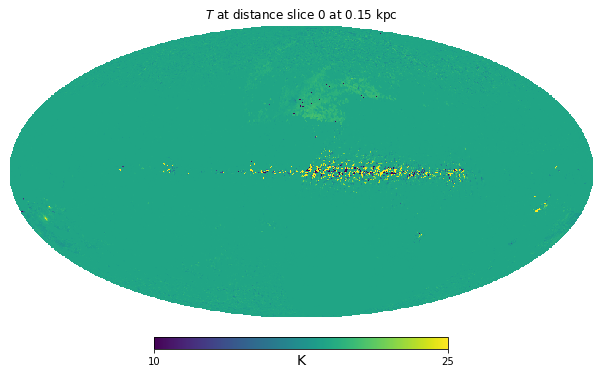

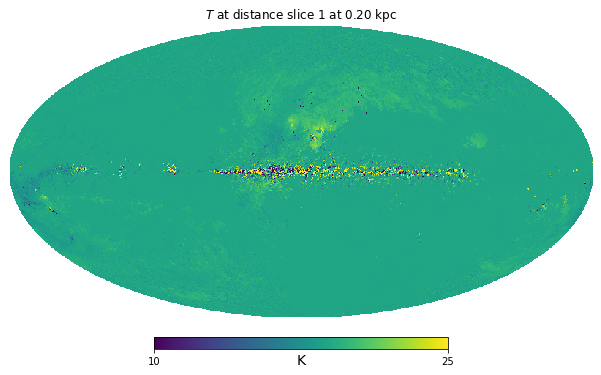

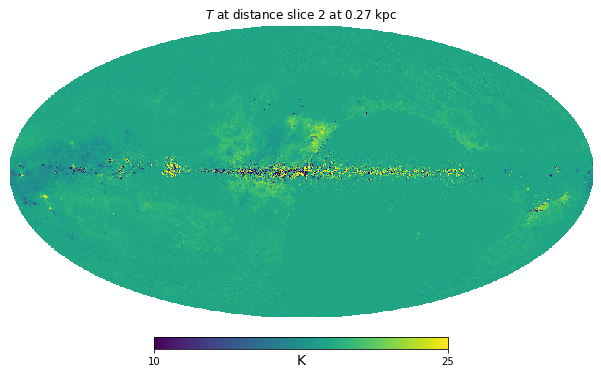

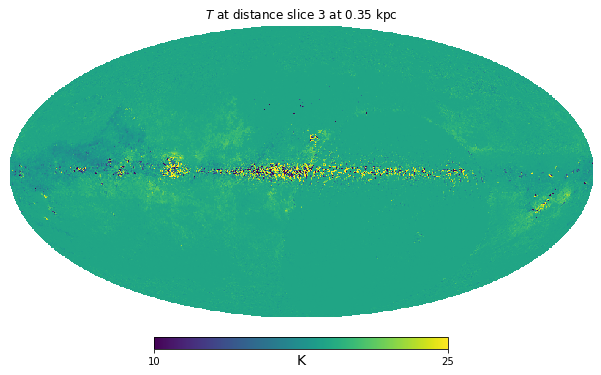

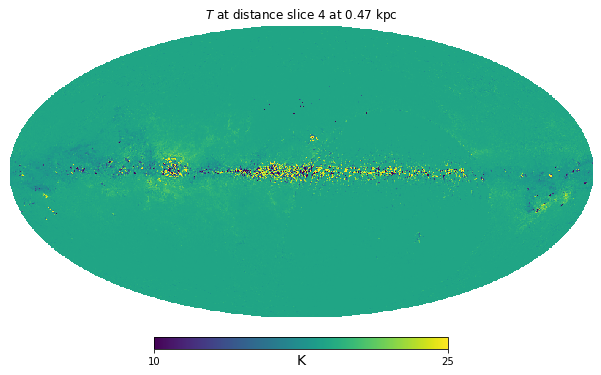

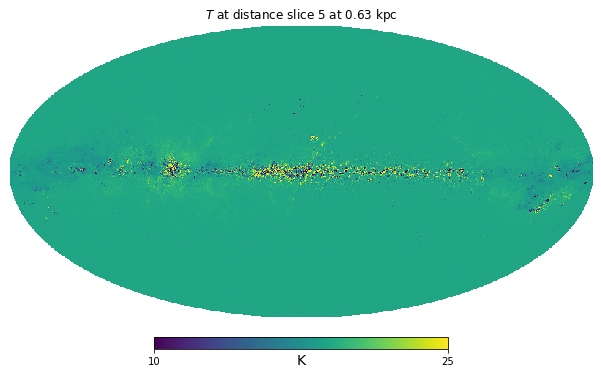

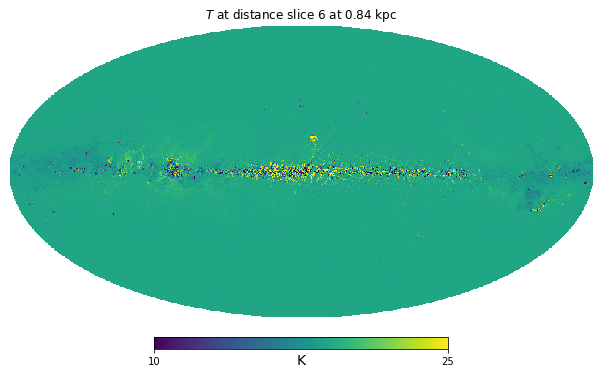

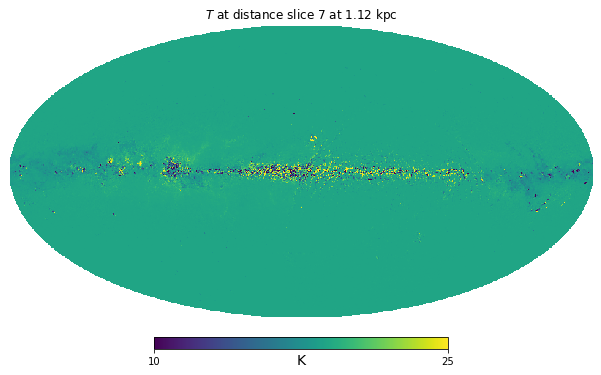

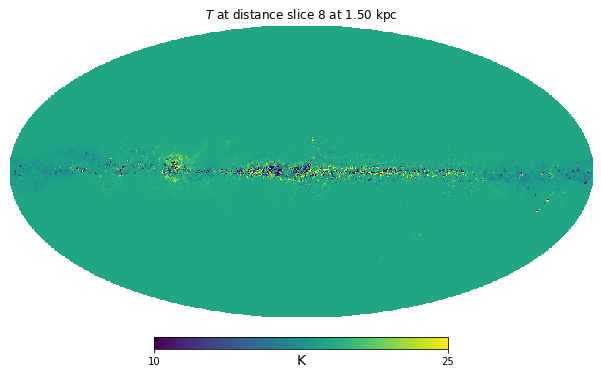

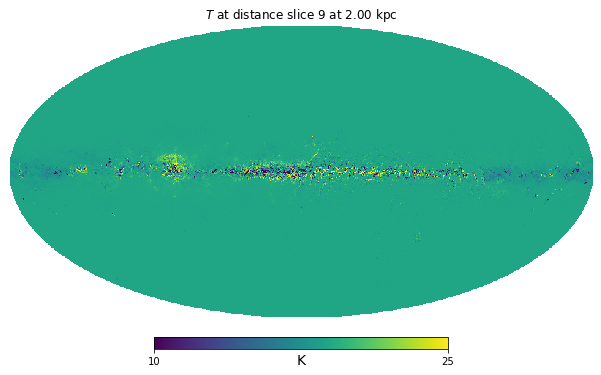

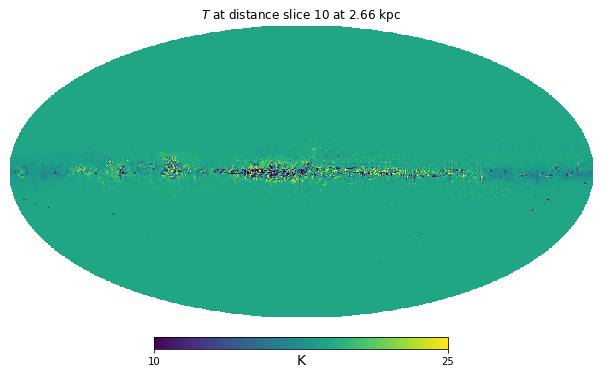

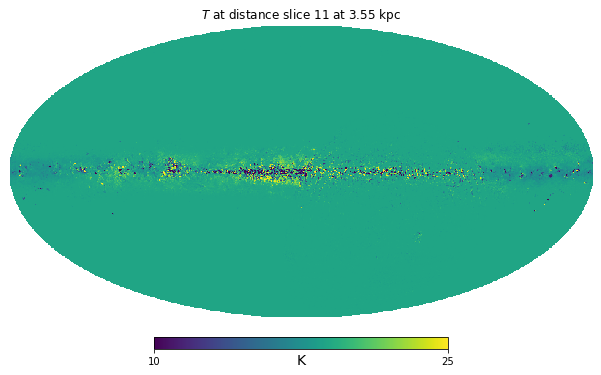

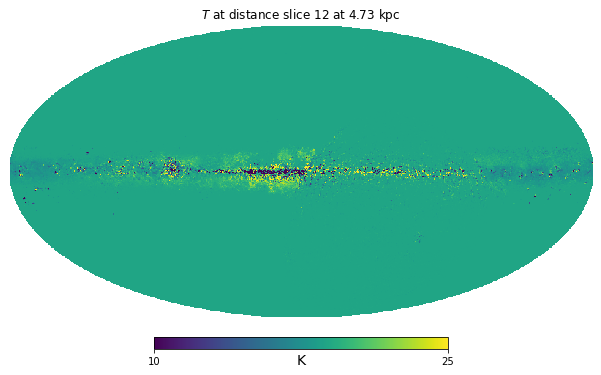

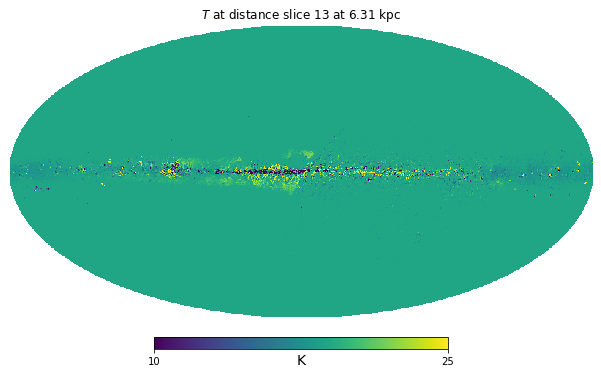

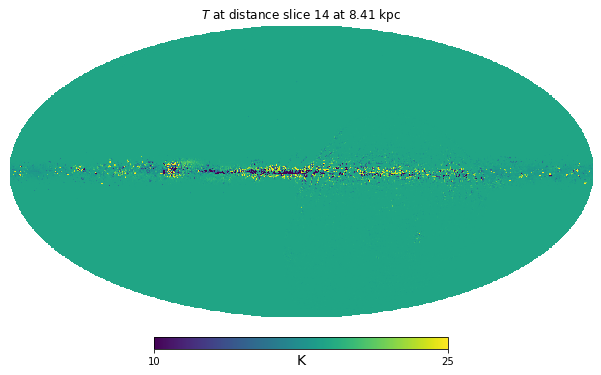

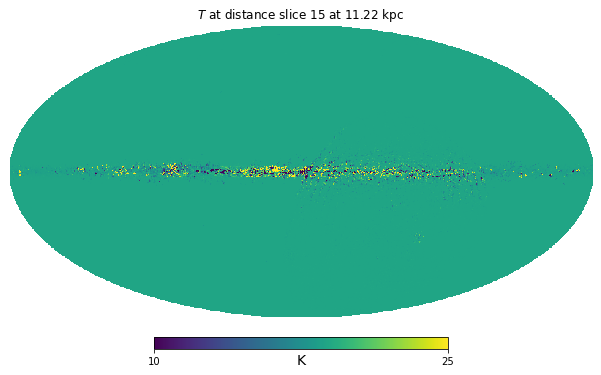

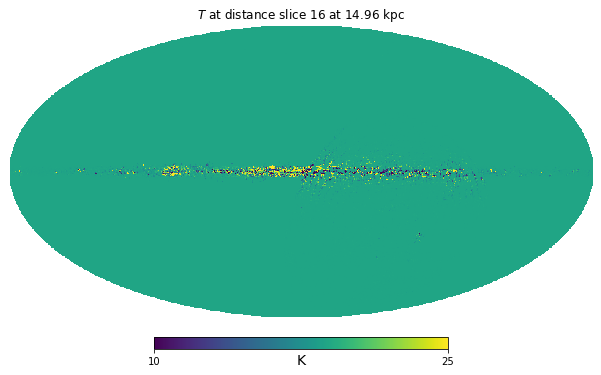

In [9]:
for ds_index in range(model_nslices):                                 
    hp.mollview(Ts_new[ds_index],title=r"$T$ at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=10,max=25, unit='K')

In [13]:
def Planck (nu, Tmap):
    x_d = h*nu/(k*Tmap)
    return 2*h*nu**3/c**2/(np.exp(x_d)-1)


def WiensLaw(T):
    nu_max = 2.824*k*T/h
    return nu_max

freq1 = WiensLaw(10)*(1E-9) ## Get it in GHz
freq2 = WiensLaw(18.8)*(1E-9)
freq3 = WiensLaw(30)*(1E-9)
print(freq1, freq2, freq3)

588.4261240427707 1106.241113200409 1765.2783721283122


In [14]:
newmap1 = Planck(freq1, Ts_new)
newmap2 = Planck(freq2, Ts_new)
newmap3 = Planck(freq3, Ts_new)

### Plotting Planck Maps

In [ ]:
for ds_index in range(model_nslices):                                 
    hp.mollview(newmap1[ds_index],title=r"$B$ for 588 GHz at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=1E-34, max=4E-33, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

In [ ]:
for ds_index in range(model_nslices):                                 
    hp.mollview(newmap2[ds_index],title=r"$B$ for 1106 GHz at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min = 1E-33, max = 1E-32, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

In [ ]:
for ds_index in range(model_nslices):                                 
    hp.mollview(newmap3[ds_index],title=r"$B$ for 1765 GHz at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min = 4E-33, max = 3E-32, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

In [15]:
dEBV = data_dict["dEBV"]

#Create new dimension with frequency
planck_maps = np.stack([newmap1,newmap2,newmap3], axis=0)
print(f"Shape of planck_maps: {planck_maps.shape}") #Check shape (which is correct)

#Initialize new dictionary
dens_temp = {}


Shape of planck_maps: (3, 17, 12582912)


In [16]:
#Calculate reddening X temperature for each frequency, at each distance slice
for f_index in range(3):
    #Initialize dens_temp for each frequency 
    dens_temp[f_index] = np.zeros((model_nslices, len(planck_maps[f_index, 0])))
    
    for ds_index in range(model_nslices):
        #Perform multiplication
        dens_temp[f_index, ds_index] = dEBV[ds_index]*planck_maps[f_index, ds_index]


### Plotting E(B-V) and B

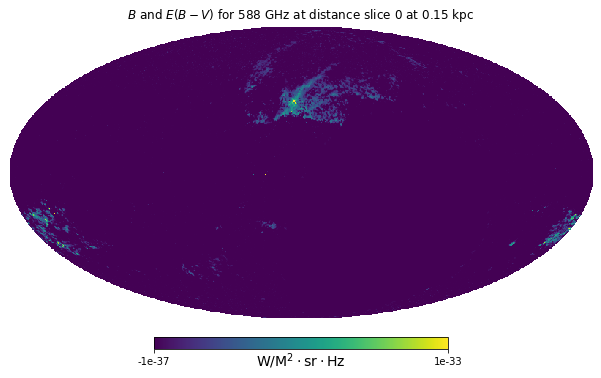

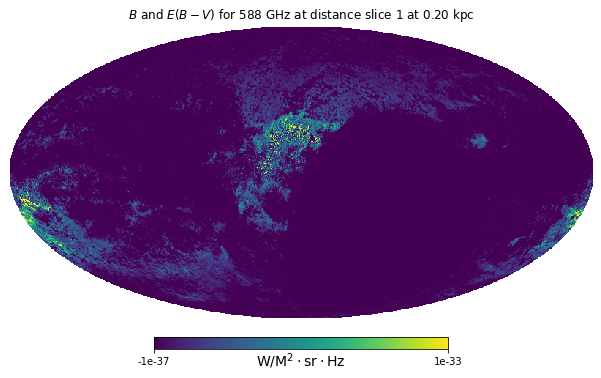

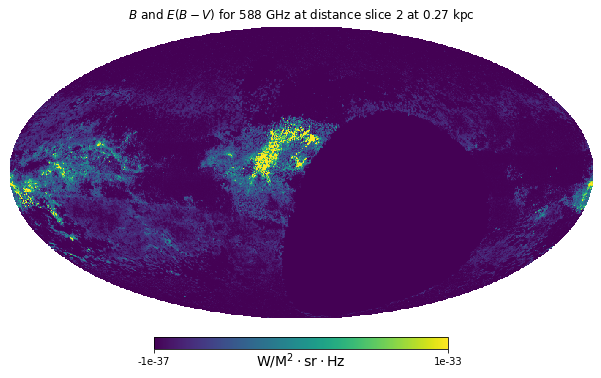

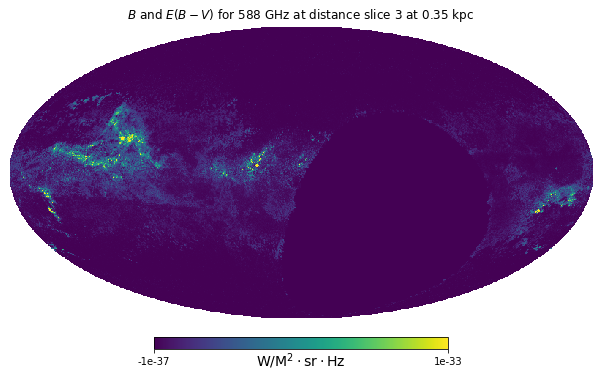

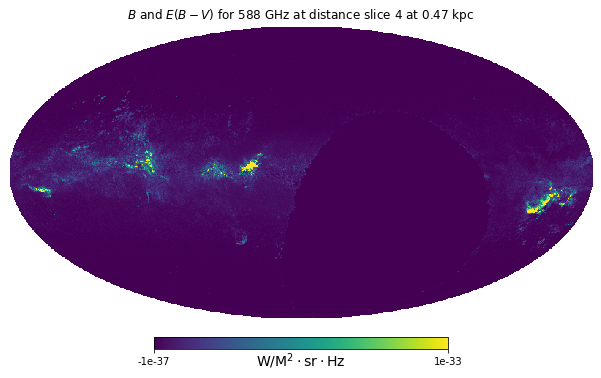

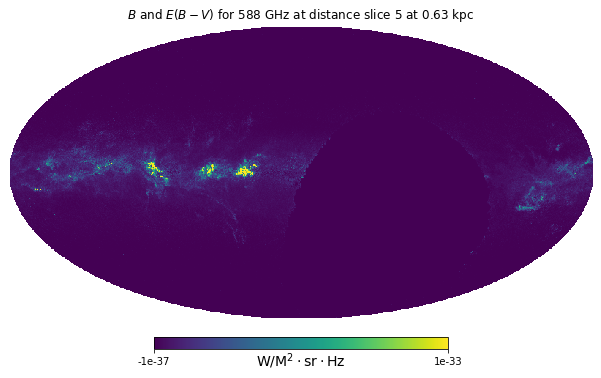

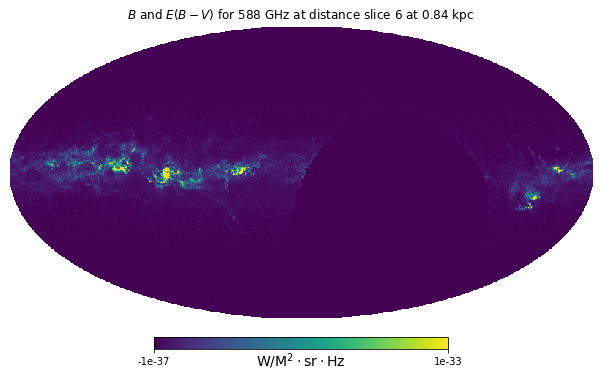

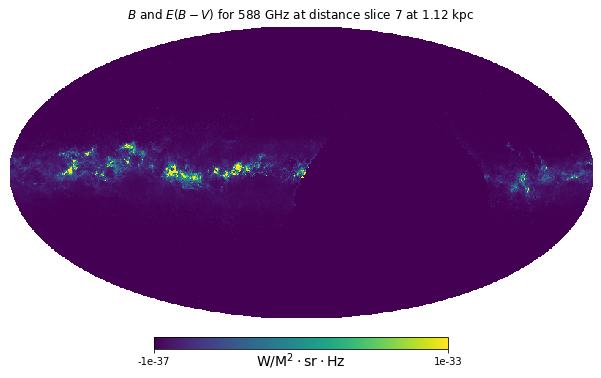

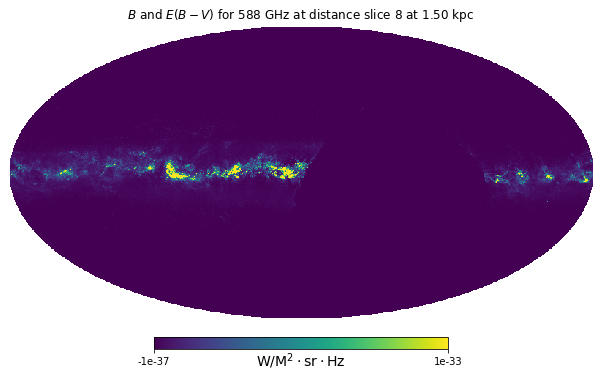

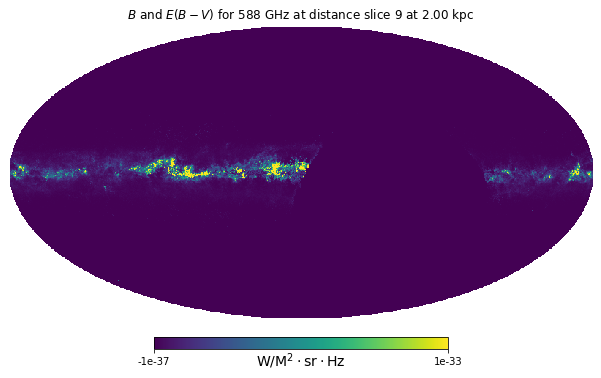

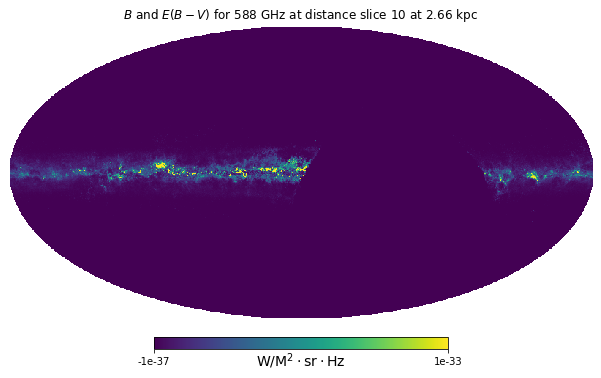

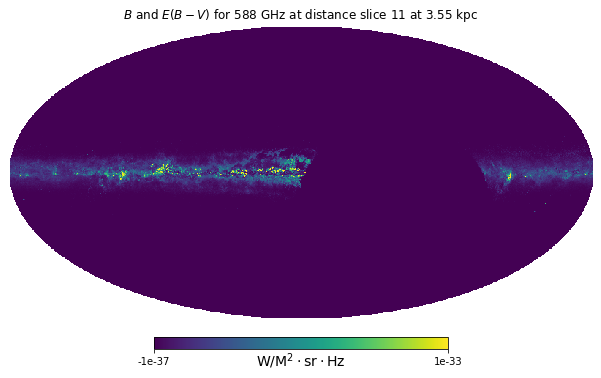

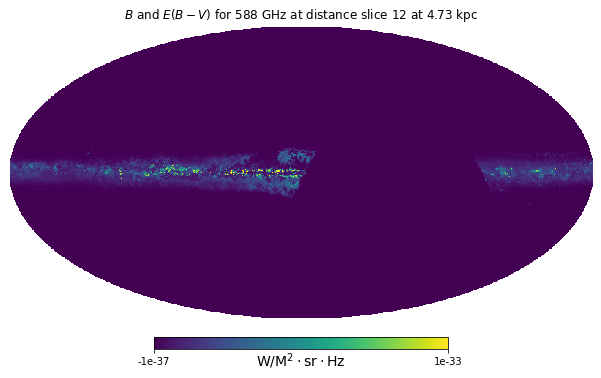

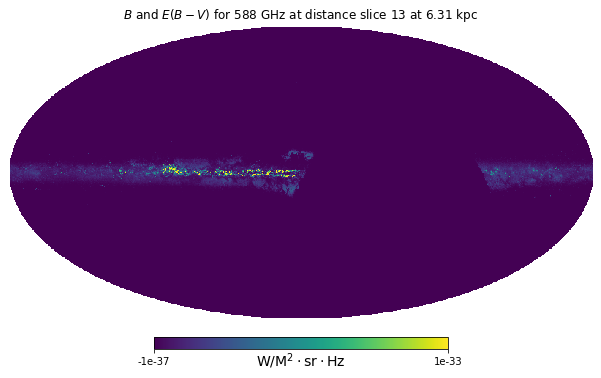

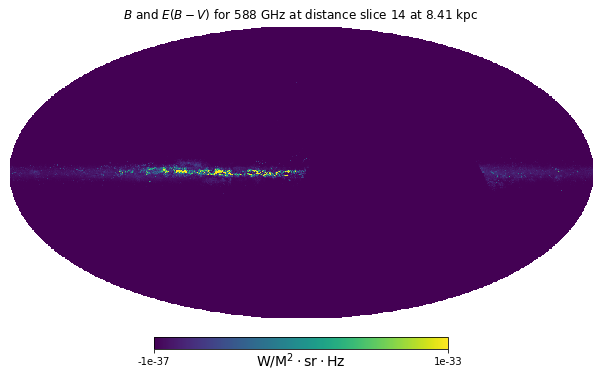

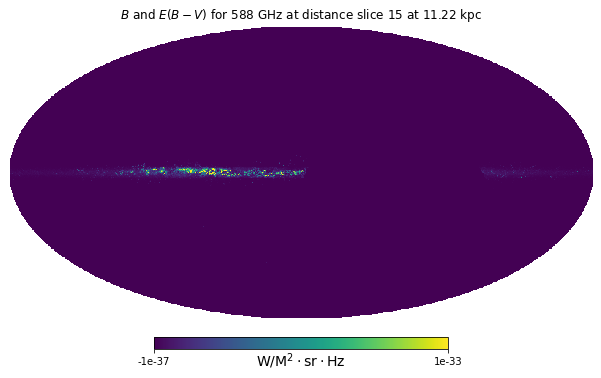

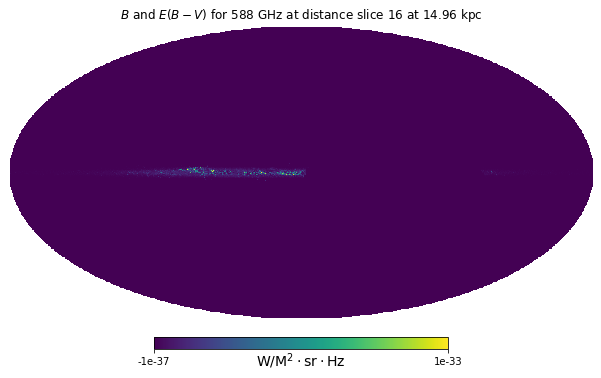

In [38]:
for ds_index in range(model_nslices):                                 
    hp.mollview(dens_temp[0, ds_index],title=r"$B$ and $E(B-V)$ for 588 GHz at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True, min = -1E-37, max = 1E-33, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

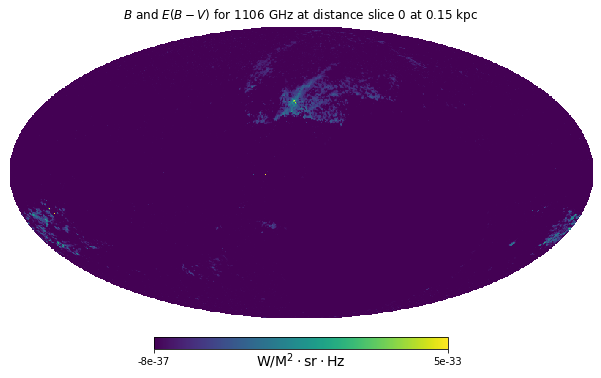

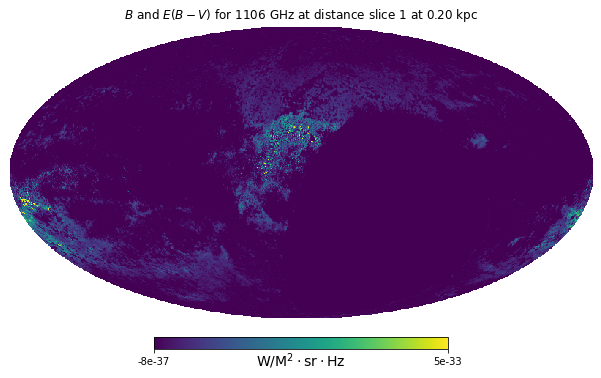

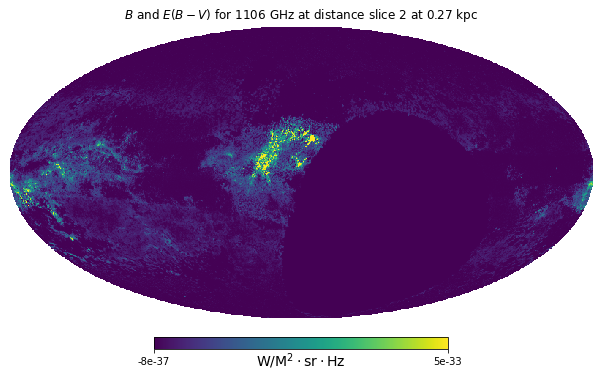

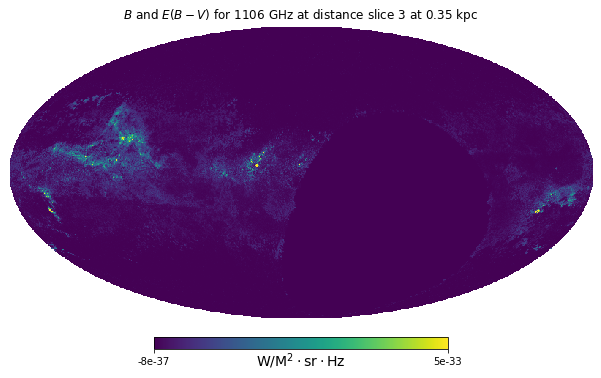

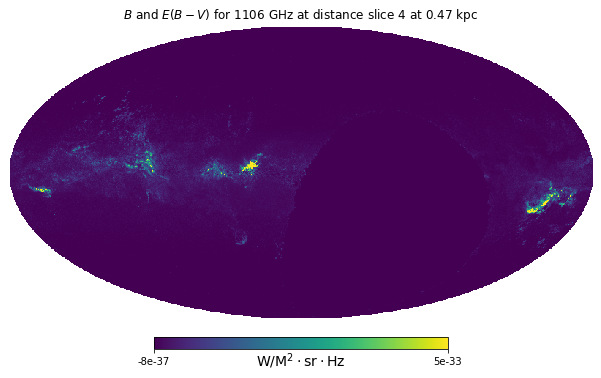

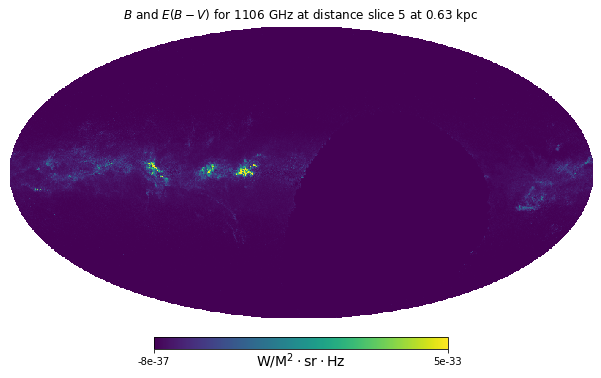

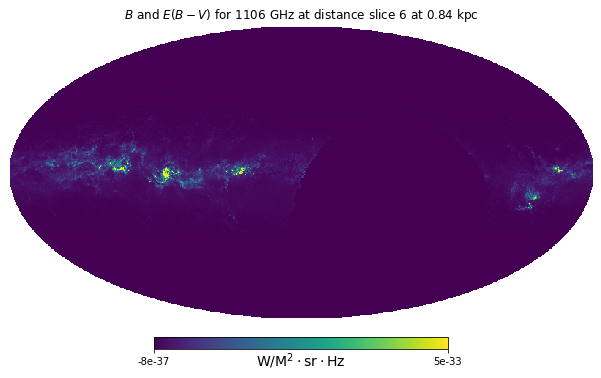

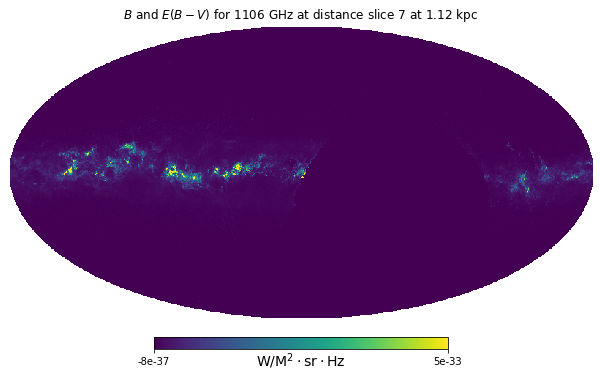

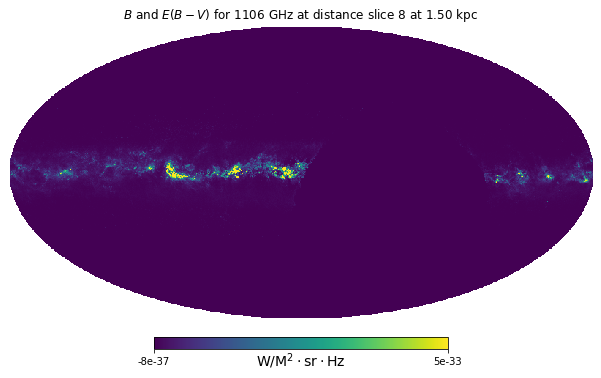

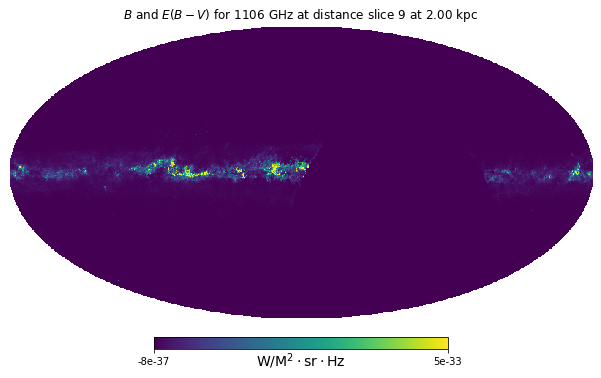

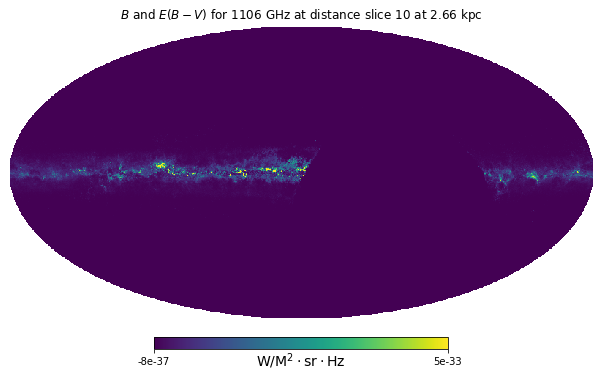

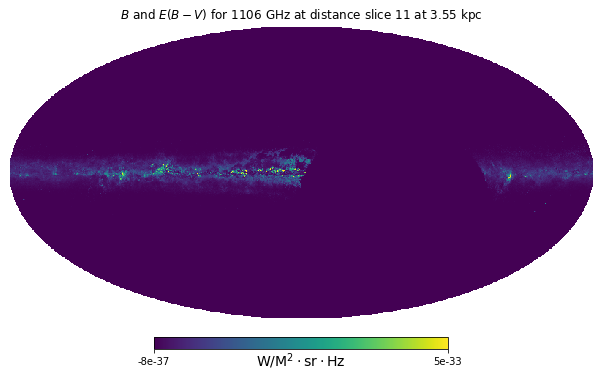

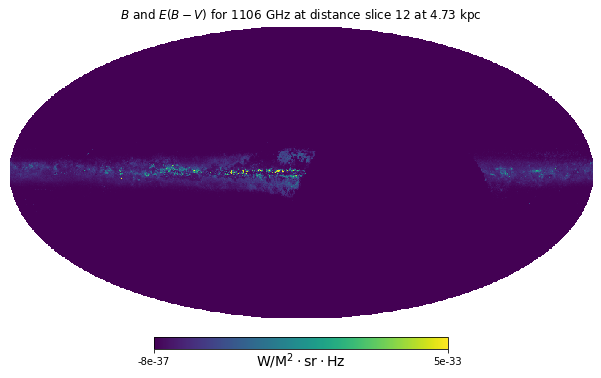

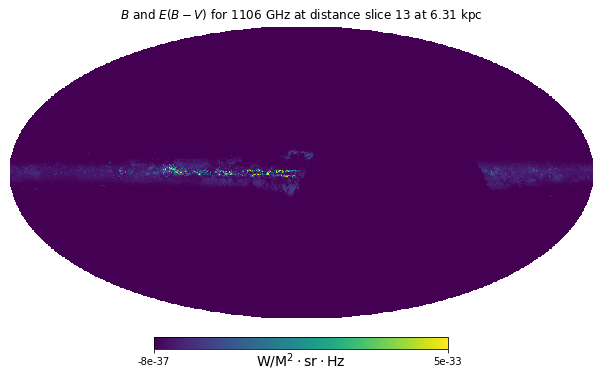

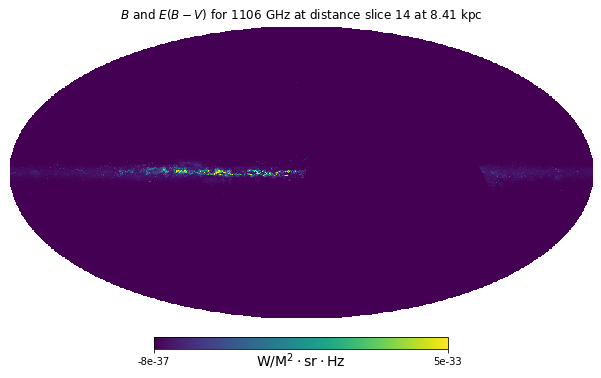

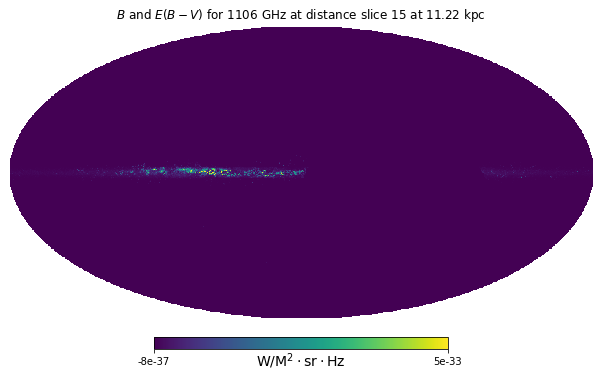

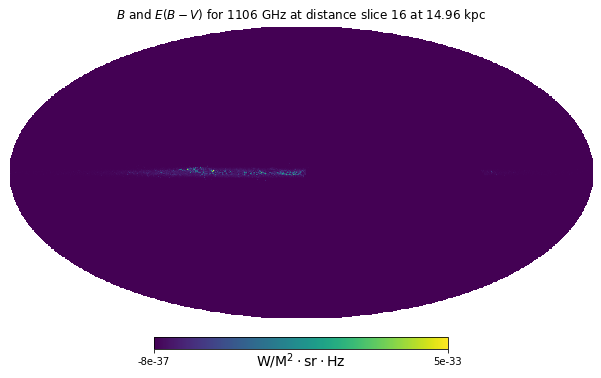

In [39]:
for ds_index in range(model_nslices):                                 
    hp.mollview(dens_temp[1, ds_index],title=r"$B$ and $E(B-V)$ for 1106 GHz at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min = -8E-37, max = 5E-33, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

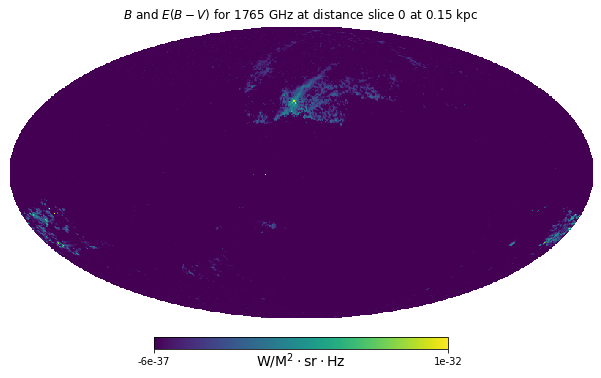

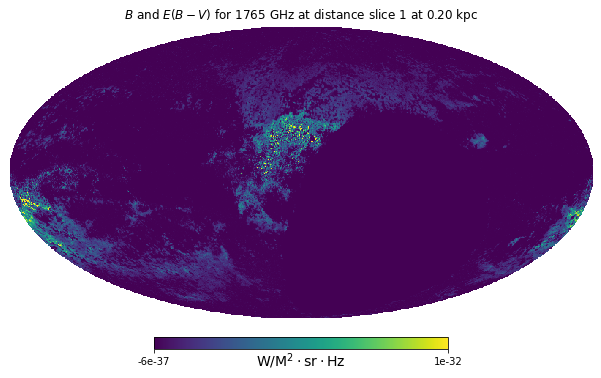

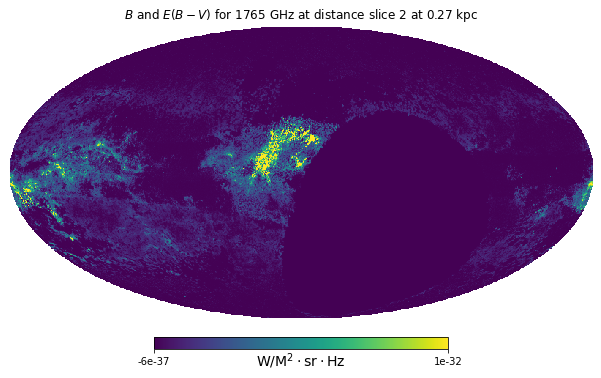

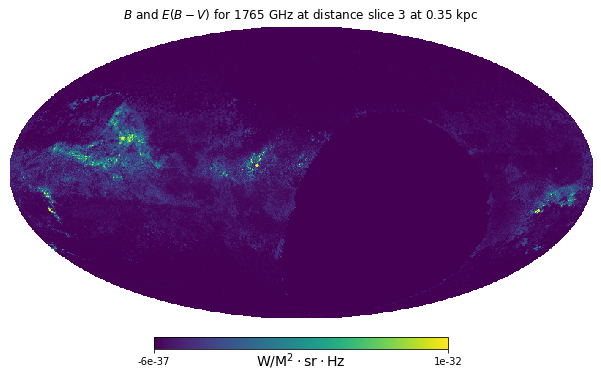

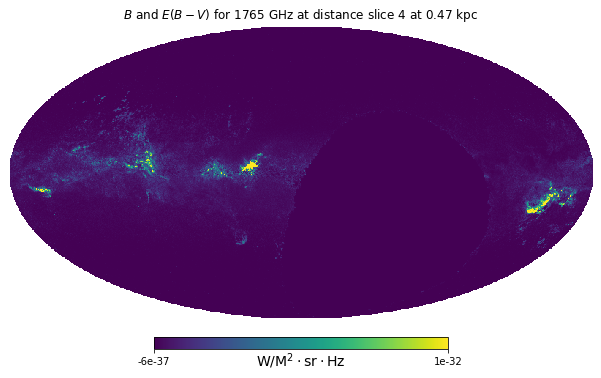

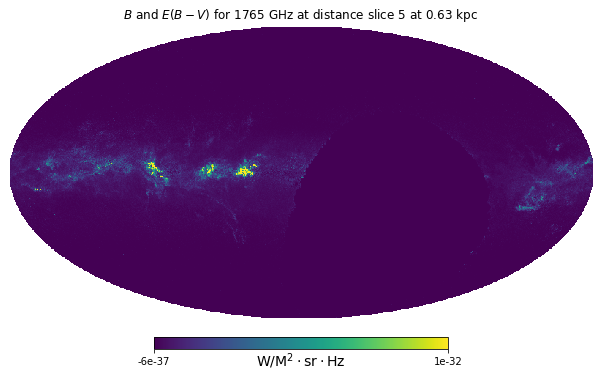

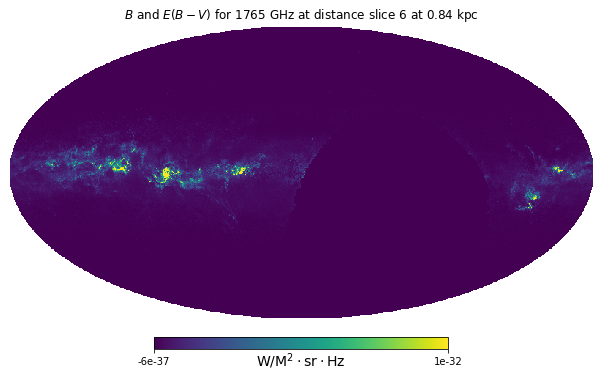

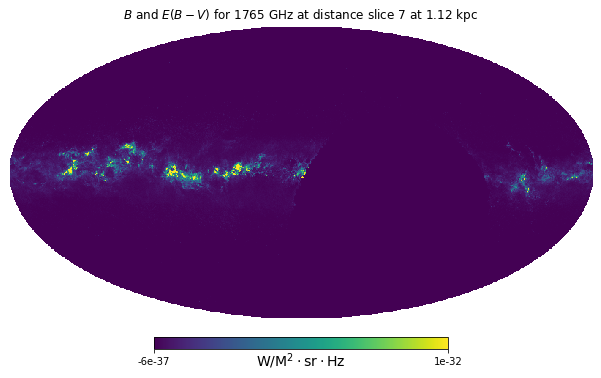

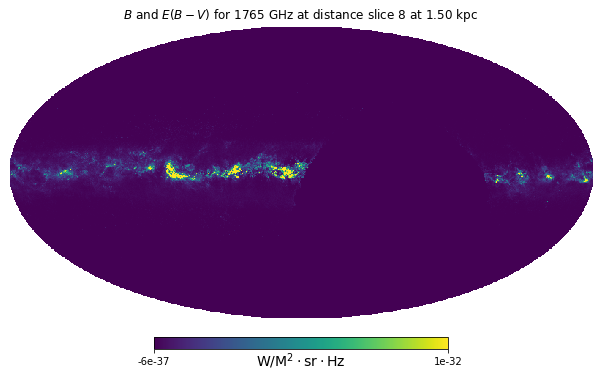

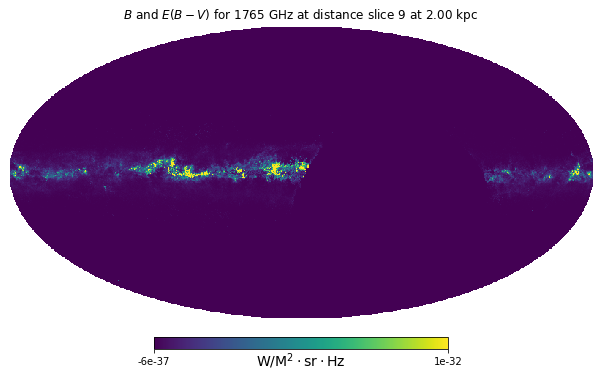

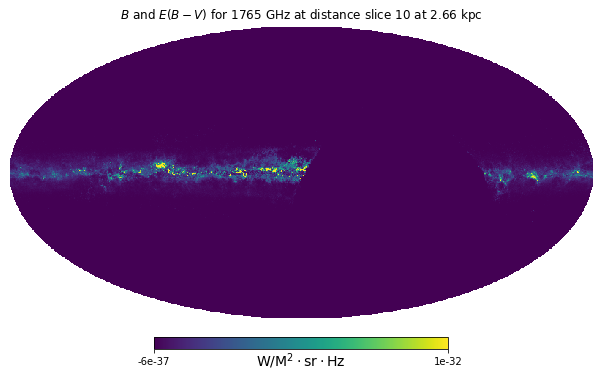

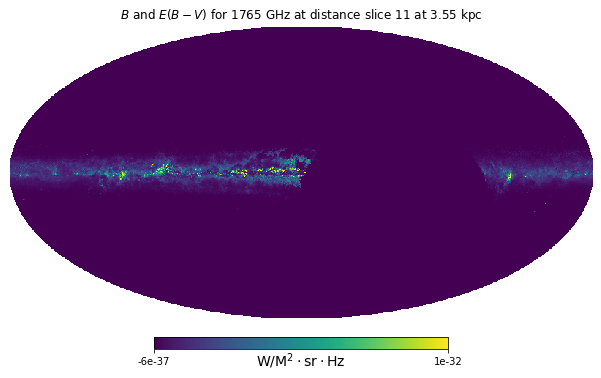

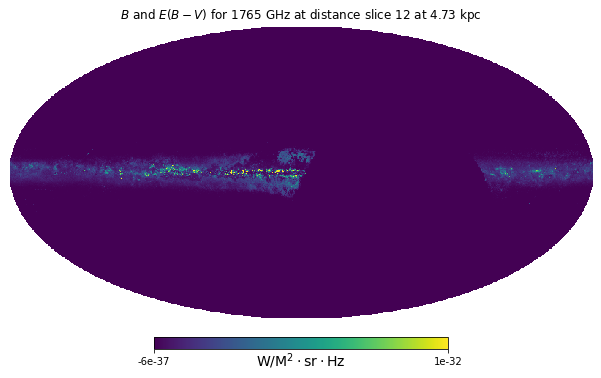

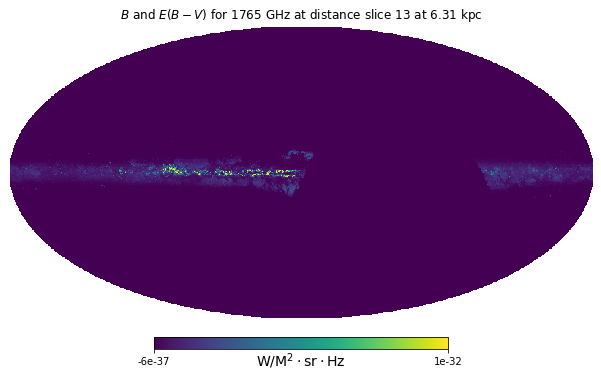

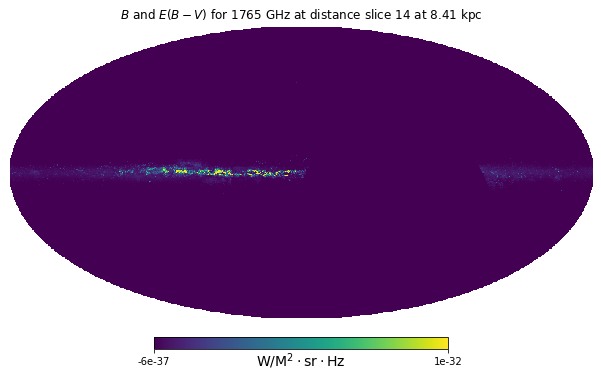

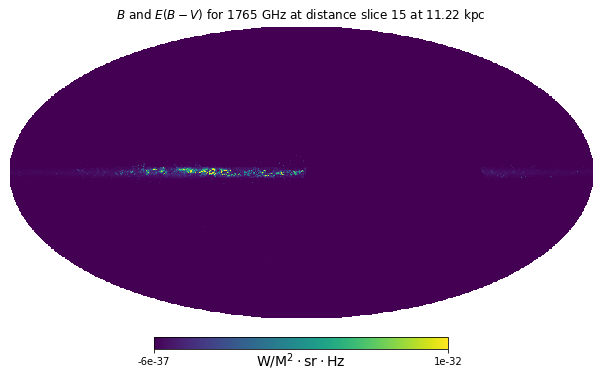

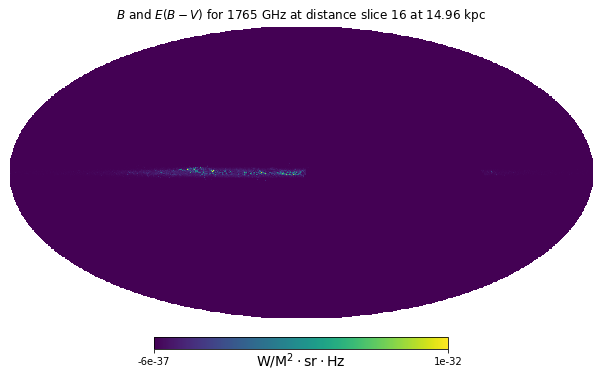

In [40]:
for ds_index in range(model_nslices):                                 
    hp.mollview(dens_temp[2, ds_index],title=r"$B$ and $E(B-V)$ for 1765 GHz at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True, min = -6E-37, max = 1E-32, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

6.22974834745096e-32


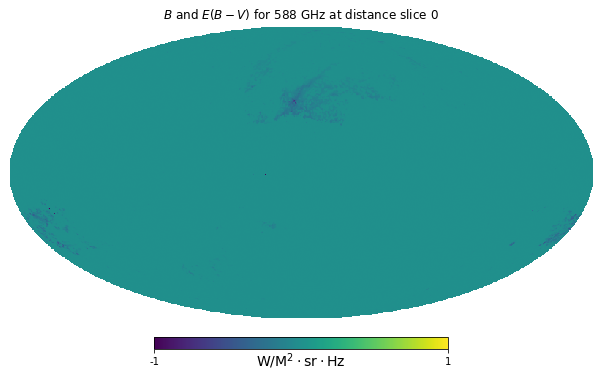

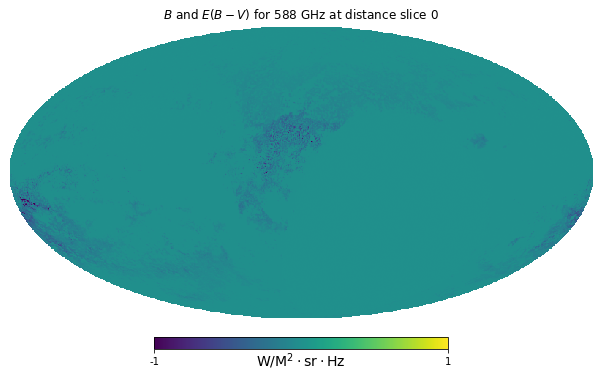

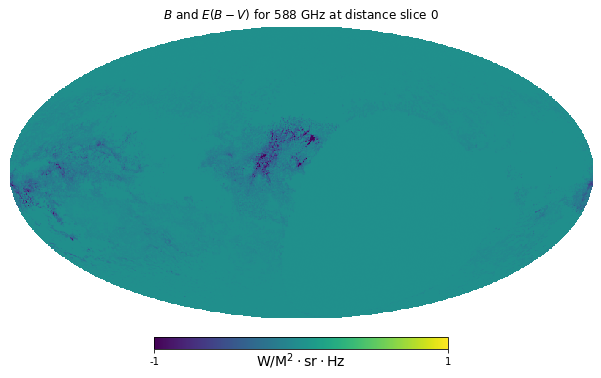

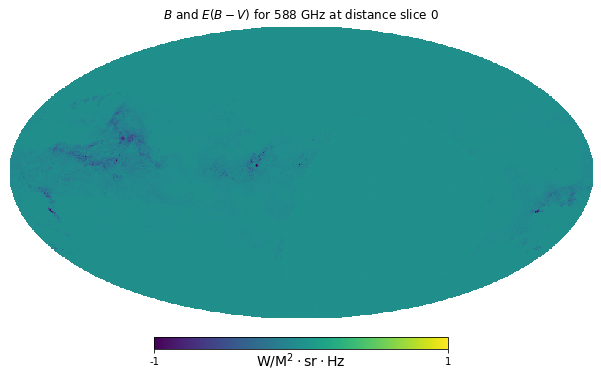

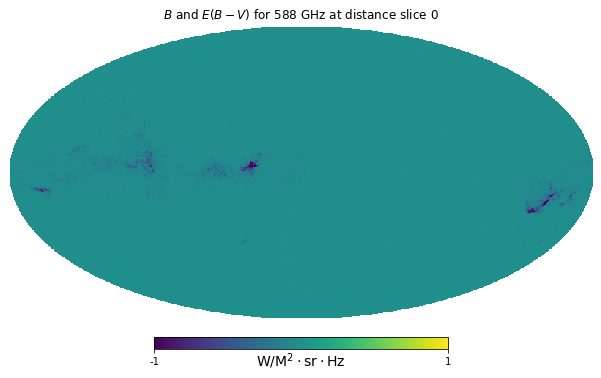

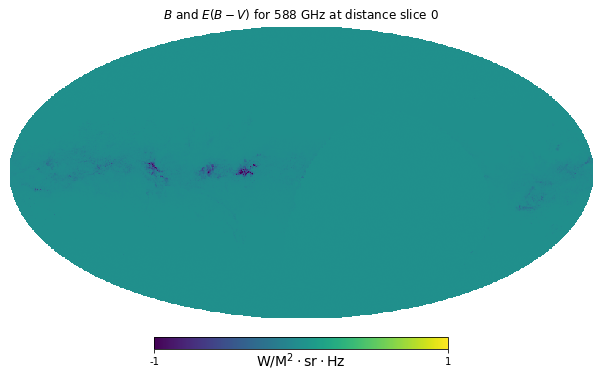

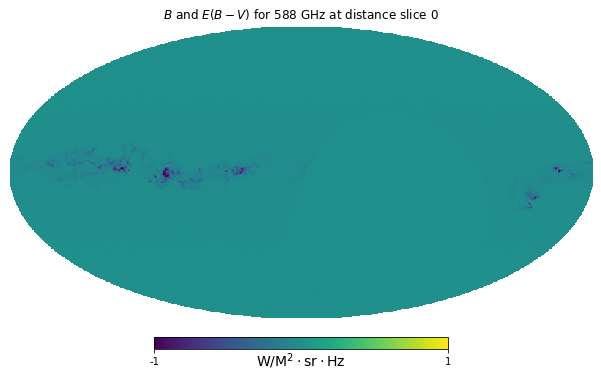

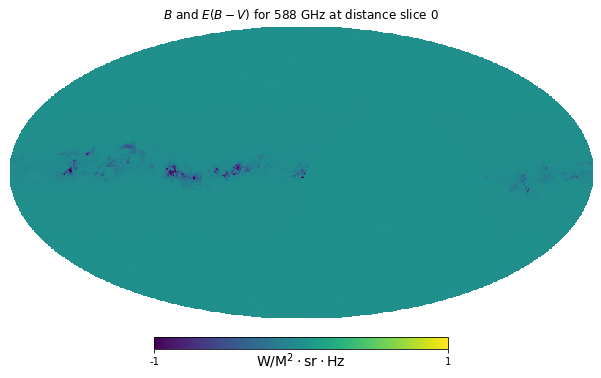

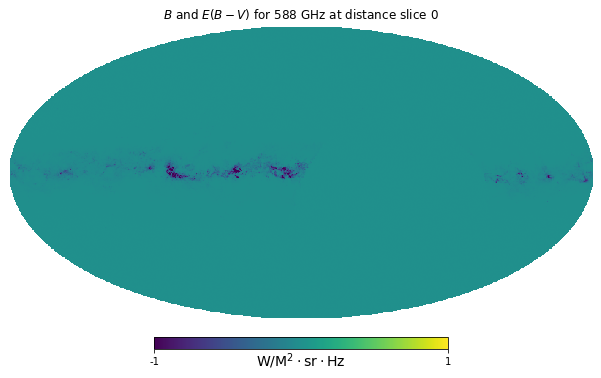

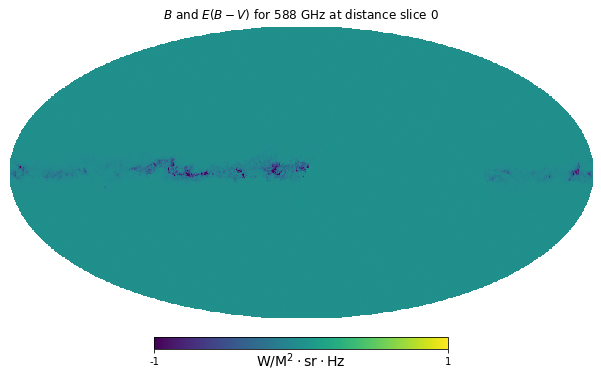

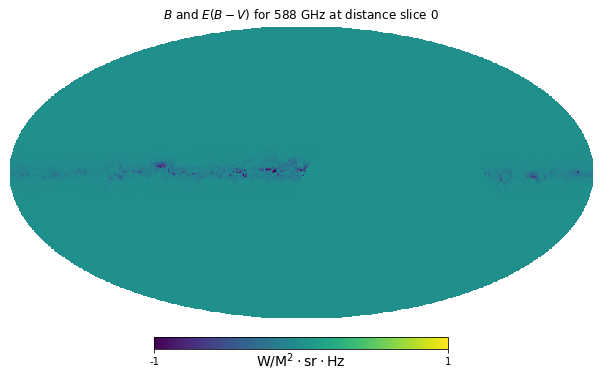

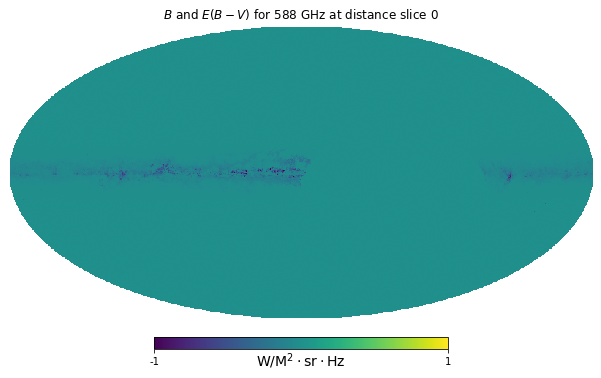

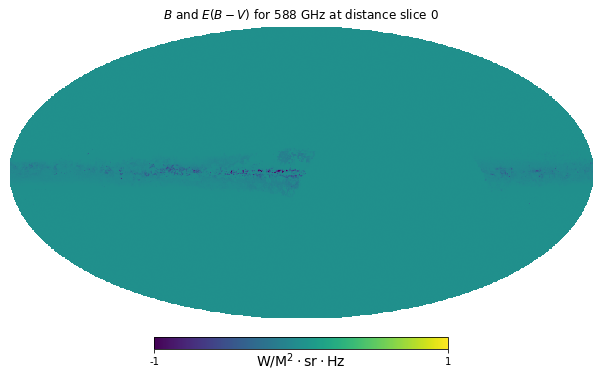

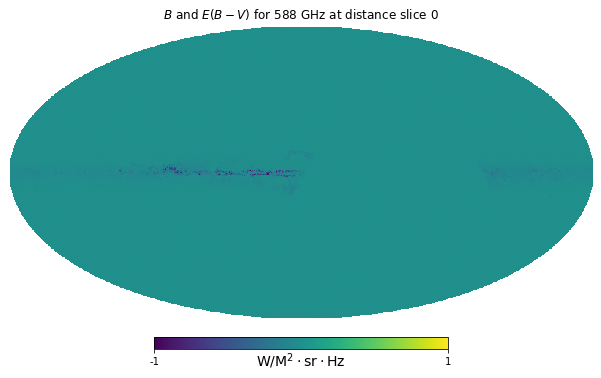

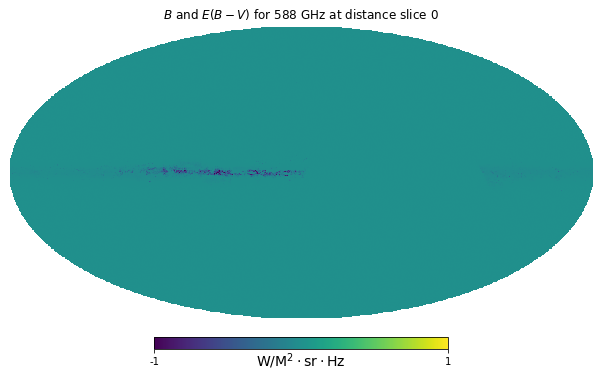

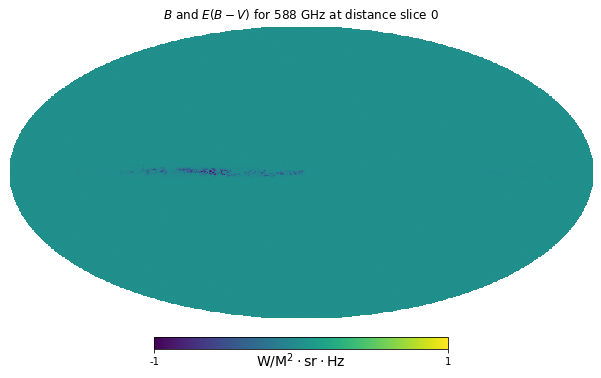

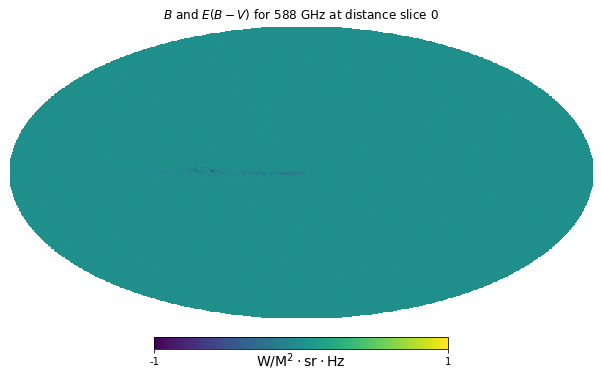

In [17]:
max_distance = np.zeros(model_nslices) ##Will be array of max value at each distance
max_individ = np.zeros((model_nslices, 3)) ##Will be array of max value at each frequency

for ds_index in range(model_nslices):
    for f_index in range(3):
        max_individ[ds_index, f_index] = np.max(dens_temp[f_index, ds_index])

    max_distance[ds_index] = np.max(max_individ[ds_index])


max_overall = np.max(max_distance)

print(max_overall)

dens_temp_norm = {}

for f_index in range(3):
    for ds_index in range(model_nslices):
        dens_temp_norm[f_index, ds_index] = dens_temp[f_index, ds_index]/max_overall

dEBV_diff = {}

for f_index in range(3):
    dEBV_diff[f_index] = np.zeros((model_nslices, len(planck_maps[0, 0])))
    for ds_index in range(model_nslices):
        dEBV_diff[f_index, ds_index] = dens_temp_norm[f_index, ds_index] - dEBV[ds_index]

for ds_index in range(model_nslices):
    hp.mollview(dEBV_diff[0, ds_index], title=r"$B$ and $E(B-V)$ for 588 GHz at distance slice 0",nest=True, min = -1, max = 1, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

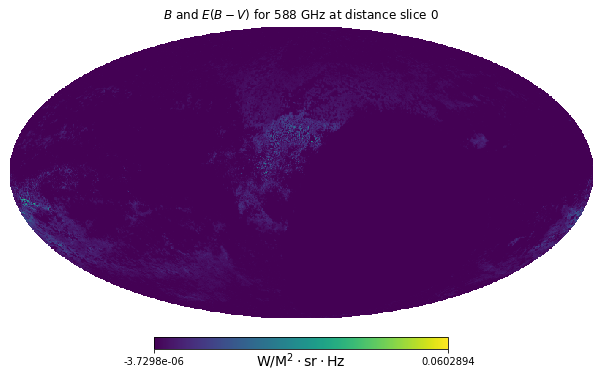

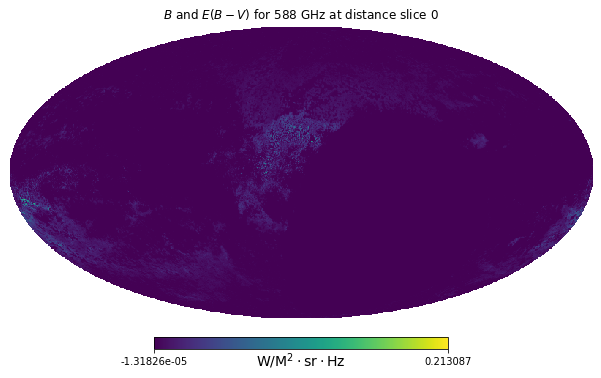

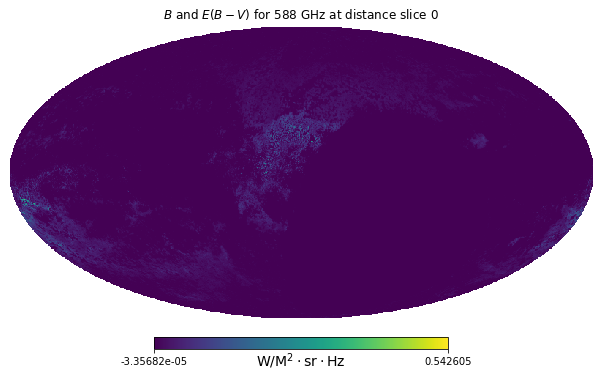

In [19]:
##Testing to see how image SHOULD look

hp.mollview(dens_temp_norm[0, 1], title=r"$B$ and $E(B-V)$ for 588 GHz at distance slice 0",nest=True, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')
hp.mollview(dens_temp_norm[1, 1], title=r"$B$ and $E(B-V)$ for 588 GHz at distance slice 0",nest=True, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')
hp.mollview(dens_temp_norm[2, 1], title=r"$B$ and $E(B-V)$ for 588 GHz at distance slice 0",nest=True, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

In [46]:
# Create RGB arrays

for ds_index in range(model_nslices):
    R_array_2d = hp.mollview(dens_temp_norm[0, ds_index],nest=True, return_projected_map=True, title="R Channel", cbar=False)
    
    plt.close()  
    G_array_2d = hp.mollview(dens_temp_norm[1, ds_index],nest=True, return_projected_map=True, title="G Channel", cbar=False)
    plt.close()  
    B_array_2d = hp.mollview(dens_temp_norm[2, ds_index],nest=True, return_projected_map=True, title="B Channel", cbar=False)
    plt.close()  
    
    scaling_factors = [1.0, 1.0, 2.0]

    R_array = np.array(R_array_2d)
    print(R_array.shape)
    G_array = np.array(G_array_2d)
    B_array = np.array(B_array_2d)

    print(np.max(R_array))
    print(np.max(G_array))
    print(np.max(B_array))

    R_array = (R_array/np.max(R_array))*scaling_factors[0]
    G_array = (G_array/np.max(G_array))*scaling_factors[1]
    B_array = (B_array/np.max(B_array))*scaling_factors[2]



# Normalize and clip the arrays
    pixel_max = 255
    target_size = (1024, 512) 
    R_array = np.clip(pixel_max * (R_array), 0, 255).astype(np.uint8)
    G_array = np.clip(pixel_max * (G_array), 0, 255).astype(np.uint8)
    B_array = np.clip(pixel_max * (B_array), 0, 255).astype(np.uint8)

    #print(f"Unique values in R_array (slice {ds_index}): {np.unique(R_array)}")
    #print(f"Unique values in G_array (slice {ds_index}): {np.unique(G_array)}")
    #print(f"Unique values in B_array (slice {ds_index}): {np.unique(B_array)}")
    

# Stack the arrays to form an RGB image
    image = Image.merge("RGB", (Image.fromarray(R_array), Image.fromarray(G_array), Image.fromarray(B_array)))
    image = ImageOps.fit(image, target_size, method=Image.Resampling.LANCZOS)

    image = np.flipud(image)
    image = Image.fromarray(image)

# Debugging: Check the shape and dtype of the RGB array
    #print("RGB shape:", RGB.shape)
    #print("RGB dtype:", RGB.dtype)

# Display the image using matplotlib
    #plt.figure(figsize=(10, 10))
    #plt.imshow(RGB)
    #plt.axis('off')  # Hide axis
    #plt.show()

# Save the image using PIL
    #image = Image.fromarray(RGB)
    image.save(f'output_image_{ds_index}.png')

(400, 800)
0.039353248437029184
0.13909011091051585
0.35417921624230475
(400, 800)
0.06028944249001951
0.2130870055367251
0.5426049824101761
(400, 800)
0.08299647899287084
0.2933427473781397
0.7469683109358382
(400, 800)
0.05401078463444445
0.19089572994151732
0.48609708843775074
(400, 800)
0.06880816725243839
0.24319558187461668
0.6192734798403259
(400, 800)
0.0595918816974699
0.21062155498189825
0.5363269589579681
(400, 800)
0.07417565547669987
0.2621664392764099
0.6675808992902992
(400, 800)
0.061446274904845964
0.21717572217358652
0.5530164991535328
(400, 800)
0.06698887996083175
0.2367654857375
0.6028998907344278
(400, 800)
0.06143731068121673
0.2171440339508404
0.5529357961309509
(400, 800)
0.051161026128786924
0.1808235405574308
0.46044925575226453
(400, 800)
0.04224637121126341
0.14931558084608518
0.380217340901371
(400, 800)
0.04454129536023104
0.15742675587981725
0.4008716789683647
(400, 800)
0.035157726217817105
0.12426146411282939
0.3164195235156367
(400, 800)
0.03852179276

In [ ]:
plot_3D_temperature_slice_maps(data_dict)

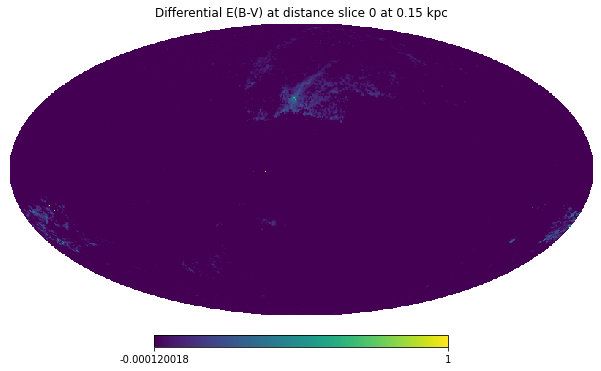

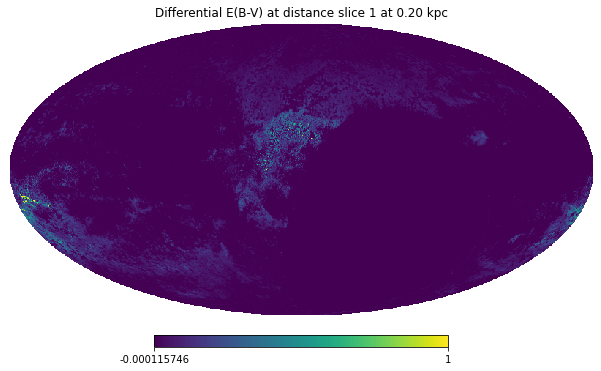

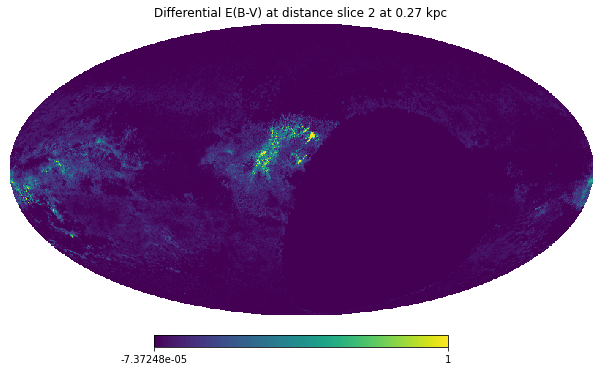

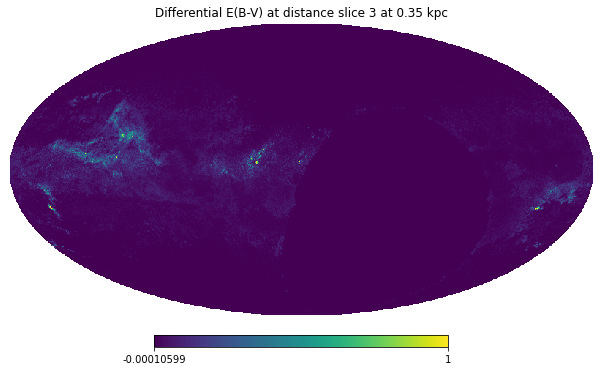

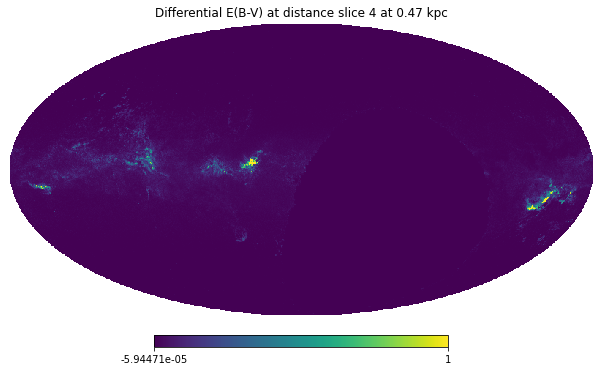

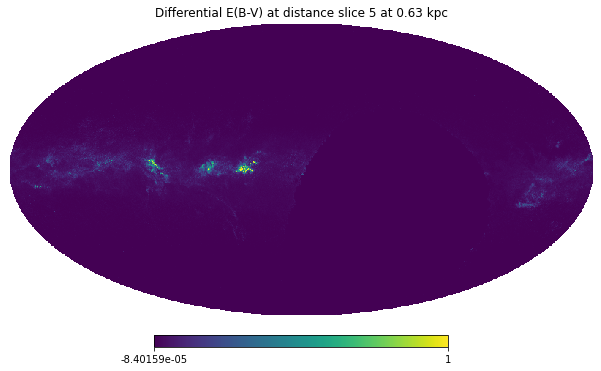

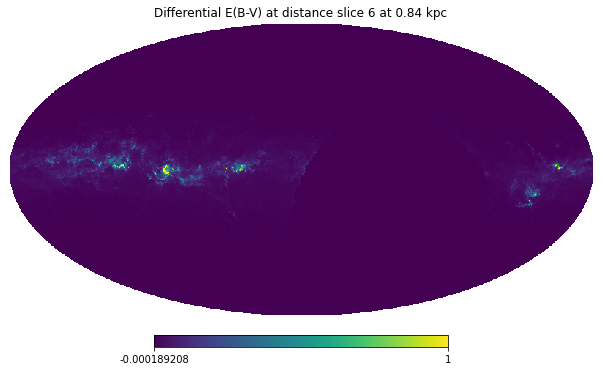

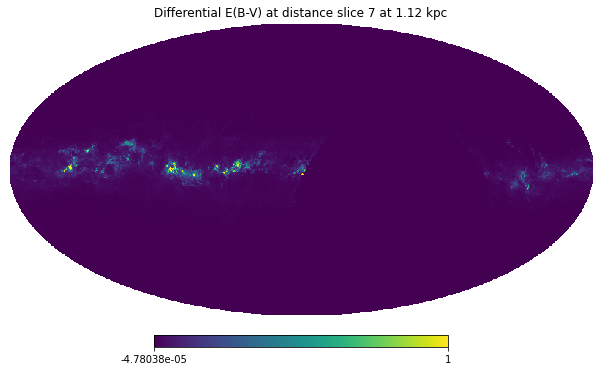

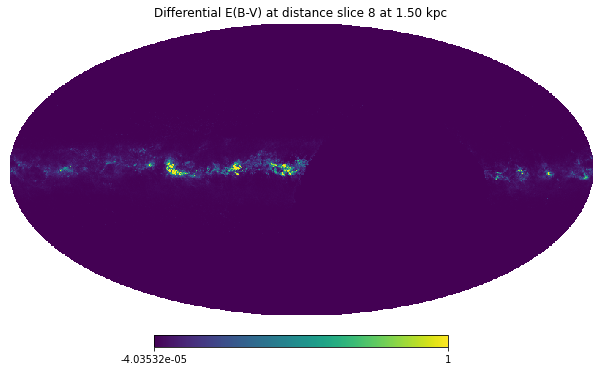

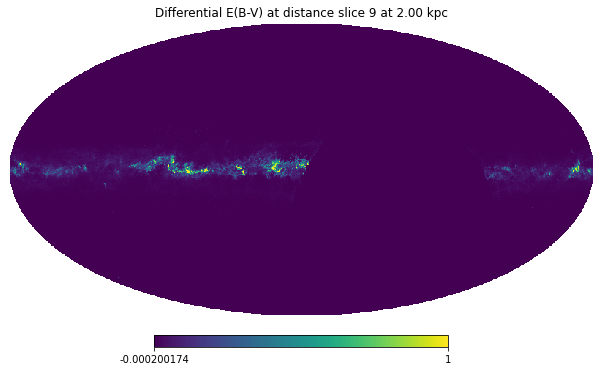

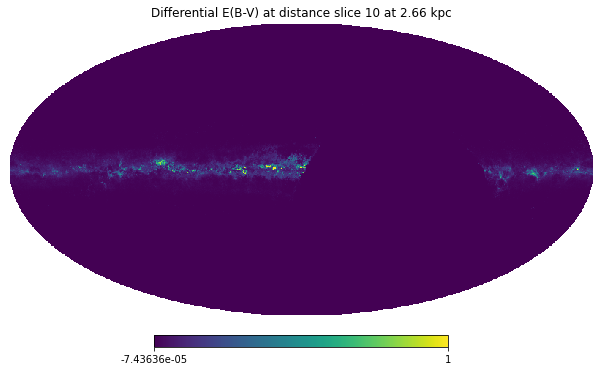

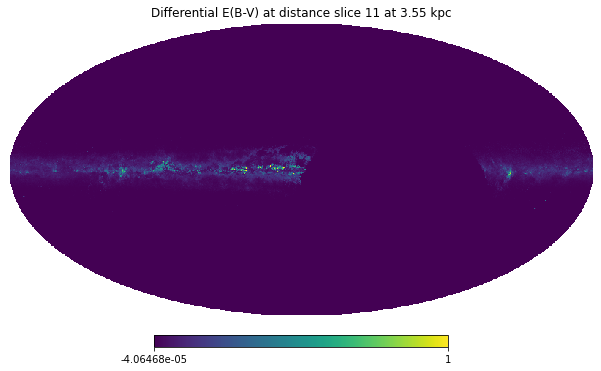

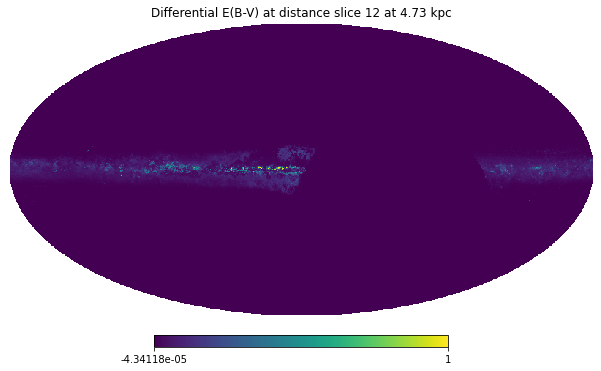

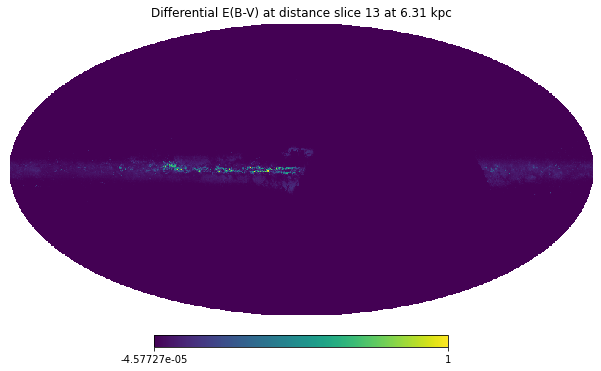

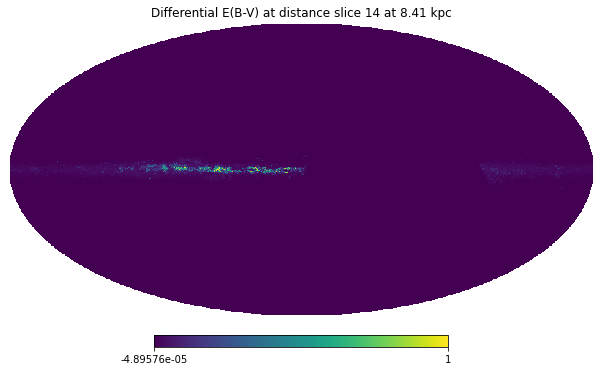

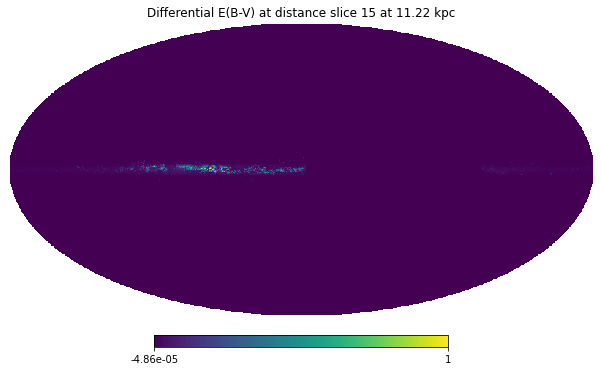

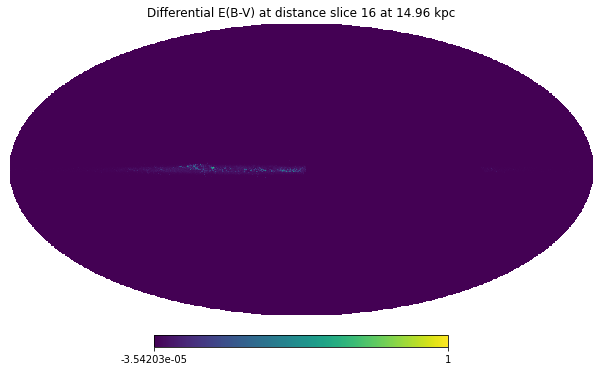

In [26]:
plot_dEBV(data_dict)
dEBV = data_dict["dEBV"]

In [27]:
# for ds_index in range(model_nslices):
#     plt.hist(data_dict["dEBV"][ds_index], bins=100)
#     plt.xlim(-0.25,0.25)
#     plt.show()

In [35]:
np.sum(dEBV<0)/dEBV.shape[0]/dEBV.shape[1]

0.34191189092748303

In [36]:
dEBV_flat = dEBV.flatten()

(-0.1, 0.1)

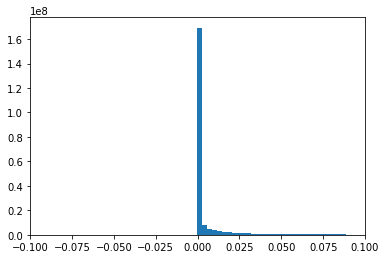

In [39]:
plt.hist(dEBV_flat, bins=1000)
plt.xlim(-0.1,0.1)

In [42]:
(np.sum(dEBV) - np.sum(np.abs(dEBV)))/2

-33.875

In [41]:
np.sum(dEBV)

1952056.0